In [3]:
# Import libraries and load data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.linalg import eigh
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import PCA

# Load MNIST data
(X_train, y_train), (_, _) = mnist.load_data()
X = X_train.reshape(-1, 28*28).astype(np.float32) / 255.
y = y_train

# Subsample for computational efficiency
n_samples = 1000
X_sub = X[:n_samples]
y_sub = y[:n_samples]

print(f"Working with {n_samples} samples of {X_sub.shape[1]}-dimensional data")
print("Data shape:", X_sub.shape)

Working with 1000 samples of 784-dimensional data
Data shape: (1000, 784)


In [4]:
# Cell 2: Step 1 - Find k-Nearest Neighbors
"""
MATHEMATICAL STEP 1: NEAREST NEIGHBORS SEARCH

For each data point x_i ∈ R^D, find its k-nearest neighbors:
N(i) = {j | x_j is one of the k nearest neighbors of x_i}

We use Euclidean distance as the metric:
d(x_i, x_j) = ||x_i - x_j||_2

This step identifies the local neighborhood structure that LLE will preserve.
"""

k = 10  # Number of neighbors
nbrs = NearestNeighbors(n_neighbors=k+1).fit(X_sub)  # +1 to include self
distances, indices = nbrs.kneighbors(X_sub)

# Remove self from neighbor indices (first column is always self)
neighbor_indices = indices[:, 1:]

print("Nearest neighbors found")
print(f"Shape of neighbor indices: {neighbor_indices.shape}")
print(f"Sample neighborhood for point 0: {neighbor_indices[0]}")

Nearest neighbors found
Shape of neighbor indices: (1000, 10)
Sample neighborhood for point 0: [832 771 652  49 964 130 125 799 549 956]


In [5]:
# Cell 3: Step 2a - Understanding the weight optimization problem
"""
MATHEMATICAL STEP 2: RECONSTRUCTION WEIGHTS

Objective: For each point x_i, find weights w_ij that minimize:
ε_i(W) = ||x_i - Σ_{j∈N(i)} w_ij * x_j||²

Constraint: Σ_{j∈N(i)} w_ij = 1 (ensures translation invariance)

This is a constrained quadratic optimization problem. We can solve it using
Lagrange multipliers or by constructing the local Gram matrix.

The solution represents how each point can be reconstructed as a linear
combination of its neighbors.
"""

# Let's examine the mathematical formulation for one point
i = 0  # First point
neighbors = neighbor_indices[i]
X_neighbors = X_sub[neighbors]
x_i = X_sub[i]

print(f"Point {i} has {len(neighbors)} neighbors")
print(f"Original point shape: {x_i.shape}")
print(f"Neighbors matrix shape: {X_neighbors.shape}")

Point 0 has 10 neighbors
Original point shape: (784,)
Neighbors matrix shape: (10, 784)


In [6]:
# Cell 4: Step 2b - Implement weight calculation for all points
"""
SOLVING THE WEIGHT OPTIMIZATION:

1. Center the neighbors: z_j = x_j - x_i
2. Build local Gram matrix: G = Z * Zᵀ where Z = [z_1, z_2, ..., z_k]ᵀ
3. Solve: G * w = 1 (system of linear equations)
4. Normalize: w = w / sum(w) to satisfy constraint Σw_ij = 1

The Gram matrix G captures the local covariance structure:
G_jk = (x_i - x_j)ᵀ(x_i - x_k) = z_jᵀ * z_k

This matrix is positive semi-definite and typically well-conditioned
for reasonable values of k.
"""

n = X_sub.shape[0]
W = np.zeros((n, n))  # Global weight matrix

for i in range(n):
    if i % 100 == 0:
        print(f"Processing point {i}/{n}")

    # Get neighbors for point i
    neighbors = neighbor_indices[i]
    X_neighbors = X_sub[neighbors]

    # Center the neighbors relative to x_i: z_j = x_j - x_i
    Z = X_neighbors - X_sub[i]

    # Build local Gram matrix G = Z * Zᵀ
    G = Z @ Z.T

    # Add small regularization to avoid numerical issues
    reg_param = 1e-3 * np.trace(G) / k
    G_reg = G + reg_param * np.eye(k)

    try:
        # Solve G * w = 1
        w = np.linalg.solve(G_reg, np.ones(k))
    except np.linalg.LinAlgError:
        # Use pseudo-inverse if matrix is singular
        w = np.linalg.pinv(G_reg) @ np.ones(k)

    # Normalize weights to sum to 1 (enforce constraint)
    w = w / np.sum(w)

    # Store weights in the global weight matrix
    W[i, neighbors] = w

print("Weight matrix computation completed")
print(f"Weight matrix shape: {W.shape}")
print(f"Non-zero entries: {np.count_nonzero(W)}")
print(f"Sparsity: {100 * (1 - np.count_nonzero(W) / (n*n)):.2f}%")

Processing point 0/1000
Processing point 100/1000
Processing point 200/1000
Processing point 300/1000
Processing point 400/1000
Processing point 500/1000
Processing point 600/1000
Processing point 700/1000
Processing point 800/1000
Processing point 900/1000
Weight matrix computation completed
Weight matrix shape: (1000, 1000)
Non-zero entries: 10000
Sparsity: 99.00%


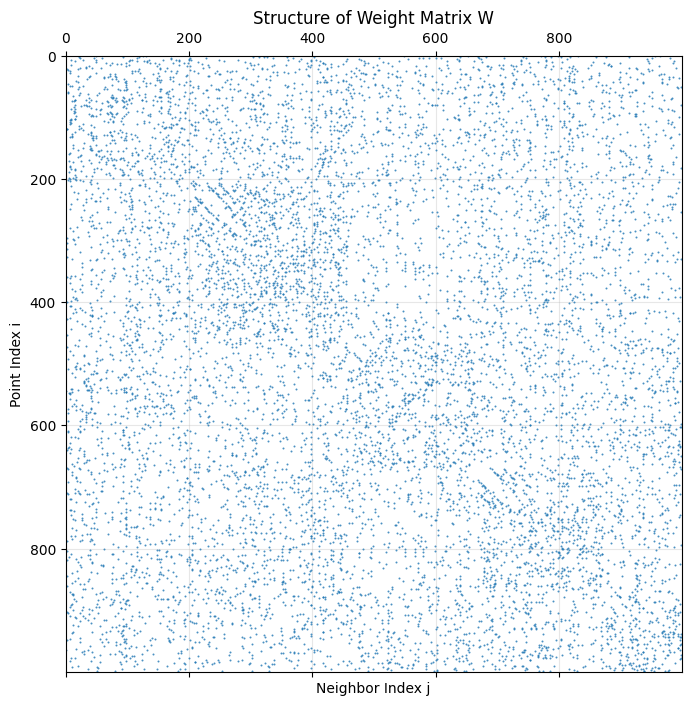

Weights for point 0:
  Neighbor 832: weight = 0.1735
  Neighbor 771: weight = 0.1039
  Neighbor 652: weight = -0.0206
  Neighbor 49: weight = 0.0328
  Neighbor 964: weight = 0.1584
  Neighbor 130: weight = 0.2119
  Neighbor 125: weight = 0.0610
  Neighbor 799: weight = 0.0612
  Neighbor 549: weight = 0.1581
  Neighbor 956: weight = 0.0598
Sum of weights: 1.000000


In [7]:
# Cell 5: Visualize the weight matrix structure
"""
THE WEIGHT MATRIX STRUCTURE:

The weight matrix W is sparse - each row has exactly k non-zero entries.
This reflects the local nature of LLE: each point only connects to its
k nearest neighbors.

The constraint Σ w_ij = 1 ensures the weights represent barycentric
coordinates within each local neighborhood.
"""

plt.figure(figsize=(10, 8))
plt.spy(W, markersize=0.5, alpha=0.7)
plt.title("Structure of Weight Matrix W")
plt.xlabel("Neighbor Index j")
plt.ylabel("Point Index i")
plt.grid(True, alpha=0.3)
plt.show()

# Show sample weights for first point
print("Weights for point 0:")
for j, weight in zip(neighbor_indices[0], W[0, neighbor_indices[0]]):
    print(f"  Neighbor {j}: weight = {weight:.4f}")
print(f"Sum of weights: {np.sum(W[0]):.6f}")

In [8]:
# Cell 6: Step 3a - Understanding the embedding optimization
"""
MATHEMATICAL STEP 3: LOW-DIMENSIONAL EMBEDDING

Objective: Find points y_i ∈ R^d that minimize:
φ(Y) = Σ_i ||y_i - Σ_j w_ij * y_j||²

Constraints:
1. Σ_i y_i = 0 (centered at origin)
2. (1/n) Σ_i y_i * y_iᵀ = I (unit covariance, prevents collapse)

This can be rewritten as:
φ(Y) = tr(Yᵀ * M * Y) where M = (I - W)ᵀ(I - W)

The solution is found by solving the eigenvalue problem:
M * v = λ * v

We discard the eigenvector with smallest eigenvalue (≈0, represents translation)
and use the next d eigenvectors for the d-dimensional embedding.
"""

# Build the cost matrix M
I = np.eye(n)
M = (I - W).T @ (I - W)

print(f"Cost matrix M shape: {M.shape}")
print(f"M is symmetric: {np.allclose(M, M.T)}")

# Check properties of M
eigenvalues = np.linalg.eigvalsh(M)
print(f"Smallest eigenvalue: {eigenvalues[0]:.6e}")
print(f"Largest eigenvalue: {eigenvalues[-1]:.3f}")

Cost matrix M shape: (1000, 1000)
M is symmetric: True
Smallest eigenvalue: -6.895935e-16
Largest eigenvalue: 7.677


In [9]:
# Cell 7: Step 3b - Compute the embedding
"""
SOLVING THE EIGENVALUE PROBLEM:

We need to find the eigenvectors of M corresponding to the smallest
non-zero eigenvalues. The eigenvector for λ≈0 represents the translation
mode and is discarded.

The embedding coordinates are given by:
Y = [v_2, v_3, ..., v_{d+1}] where v_i are eigenvectors of M

The eigenvalues represent the residual reconstruction error in the
low-dimensional space.
"""

# Find eigenvectors corresponding to the 2nd and 3rd smallest eigenvalues
eigenvalues, eigenvectors = eigh(M, subset_by_index=[1, 2])

# The eigenvectors are our 2D embedding coordinates
Y_manual = eigenvectors

print("Embedding computed")
print(f"Embedding shape: {Y_manual.shape}")
print(f"Eigenvalues: {eigenvalues}")

# Center the embedding (constraint 1)
Y_manual = Y_manual - np.mean(Y_manual, axis=0)

# Normalize to unit covariance (constraint 2)
Y_manual = Y_manual / np.std(Y_manual, axis=0)

print("Embedding centered and normalized")

Embedding computed
Embedding shape: (1000, 2)
Eigenvalues: [5.87014997e-05 7.69110884e-05]
Embedding centered and normalized


In [10]:
# Cell 8: Compare with sklearn implementation
"""
VERIFICATION AND COMPARISON:

We compare our manual implementation with sklearn's LLE to verify
our mathematical understanding. The results should be similar up to
rotation, reflection, and scaling, since these don't affect the
neighborhood preservation.
"""

from sklearn import manifold

# sklearn LLE implementation
lle = manifold.LocallyLinearEmbedding(n_neighbors=k, n_components=2, method='standard', random_state=42)
Y_sklearn = lle.fit_transform(X_sub)

# PCA for reference
pca = PCA(n_components=2)
Y_pca = pca.fit_transform(X_sub)

print("Comparison of different dimensionality reduction methods:")
print(f"Manual LLE shape: {Y_manual.shape}")
print(f"sklearn LLE shape: {Y_sklearn.shape}")
print(f"PCA shape: {Y_pca.shape}")

Comparison of different dimensionality reduction methods:
Manual LLE shape: (1000, 2)
sklearn LLE shape: (1000, 2)
PCA shape: (1000, 2)


/tmp/ipython-input-267544199.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  scatter = plt.scatter(Y_manual[:, 0], Y_manual[:, 1], c=y_sub, cmap=plt.cm.get_cmap('tab10', 10), s=15, alpha=0.8)


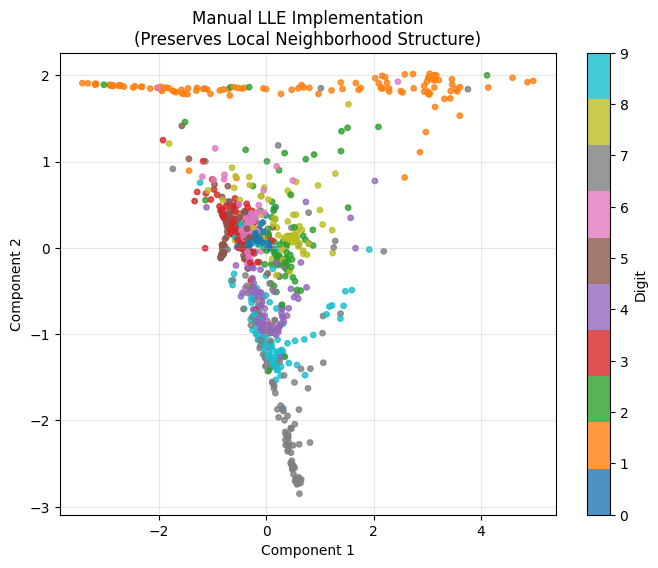

/tmp/ipython-input-267544199.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  scatter = plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=y_sub, cmap=plt.cm.get_cmap('tab10', 10), s=15, alpha=0.8)


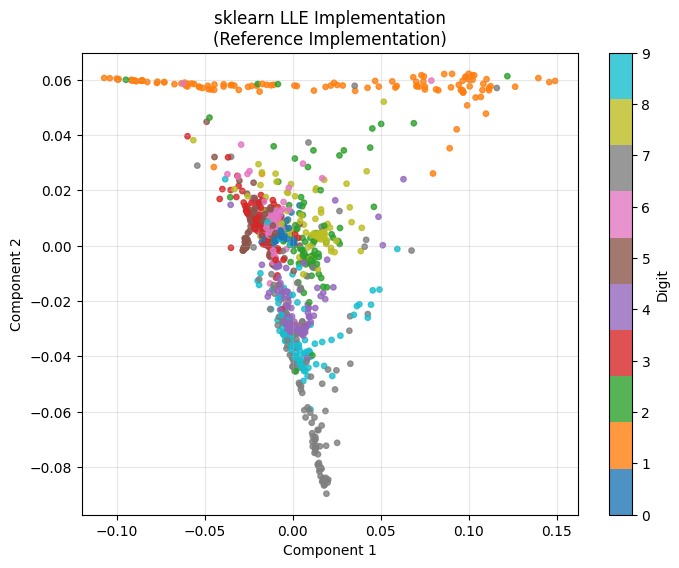

/tmp/ipython-input-267544199.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  scatter = plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=y_sub, cmap=plt.cm.get_cmap('tab10', 10), s=15, alpha=0.8)


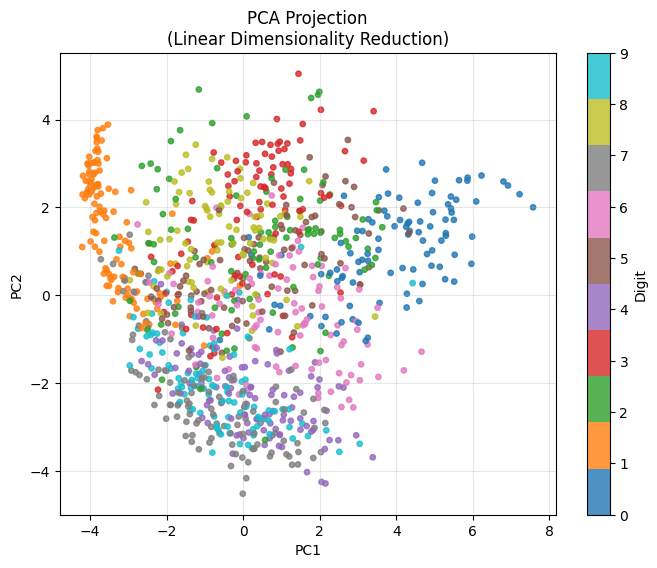

Comparison Analysis:
• LLE methods better separate digit clusters due to non-linear manifold learning
• PCA shows more overlap between digits as it's limited to linear projections
• Manual and sklearn LLE should show similar cluster structures (up to rotation/reflection)


In [13]:
# Cell 9: Visualize results one at a time
"""
VISUALIZATION AND INTERPRETATION:

We'll plot each method separately to better examine their ability to
preserve the manifold structure of MNIST digits.

LLE should preserve local neighborhoods better than PCA, resulting
in better separation of digit clusters despite the non-linear
structure of the data.
"""

# Plot 1: Manual LLE implementation
plt.figure(figsize=(8, 6))
scatter = plt.scatter(Y_manual[:, 0], Y_manual[:, 1], c=y_sub, cmap=plt.cm.get_cmap('tab10', 10), s=15, alpha=0.8)
plt.colorbar(scatter, ticks=range(10), label='Digit')
plt.title("Manual LLE Implementation\n(Preserves Local Neighborhood Structure)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True, alpha=0.3)
plt.show()

# Plot 2: sklearn LLE implementation
plt.figure(figsize=(8, 6))
scatter = plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=y_sub, cmap=plt.cm.get_cmap('tab10', 10), s=15, alpha=0.8)
plt.colorbar(scatter, ticks=range(10), label='Digit')
plt.title("sklearn LLE Implementation\n(Reference Implementation)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True, alpha=0.3)
plt.show()

# Plot 3: PCA for comparison
plt.figure(figsize=(8, 6))
scatter = plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=y_sub, cmap=plt.cm.get_cmap('tab10', 10), s=15, alpha=0.8)
plt.colorbar(scatter, ticks=range(10), label='Digit')
plt.title("PCA Projection\n(Linear Dimensionality Reduction)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.show()

print("Comparison Analysis:")
print("• LLE methods better separate digit clusters due to non-linear manifold learning")
print("• PCA shows more overlap between digits as it's limited to linear projections")
print("• Manual and sklearn LLE should show similar cluster structures (up to rotation/reflection)")